### CS 178: Machine Learning &amp; Data Mining

# Discussion 04

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import requests           # we'll use these for reading data from a url
from io import StringIO

from IPython import display

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import zero_one_loss as J01
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
    
seed=1234
_=plt.set_cmap('jet')
np.random.seed(seed)

<Figure size 432x288 with 0 Axes>

# Linear Classifiers and Feature Transforms

Let's start with some simple data for a classification example.  We'll use two features, $(x_1,x_2)$, and two classes, positive and negative (+1 vs. -1).

In [ ]:
X, y = make_moons(n_samples=1000,noise=0.1)
y[y==0] = -1     # make {-1,1} instead of {0,1}

Xtr, Xte, ytr, yte = train_test_split(X, y)

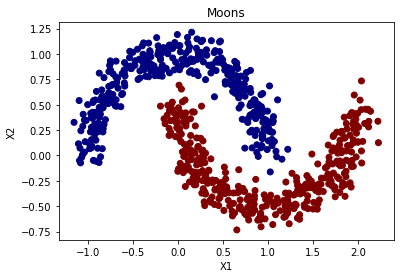

In [ ]:
fig, ax = plt.subplots()

ax.scatter(Xtr[:,0], Xtr[:,1], c=ytr);   # scatter plot, using "y" as the color
ax.set_title("Moons"); 
ax.set_xlabel("X1");
ax.set_ylabel("X2");

## Linear Classifier

In [ ]:
learner = LogisticRegression()
learner.fit(Xtr,ytr);

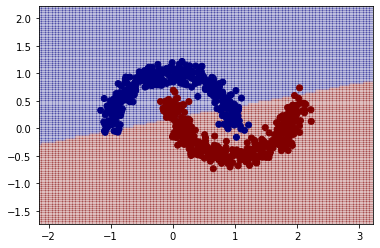

Error rate: 0.1293


In [ ]:
plot_kwargs = {'cmap':'jet', 
               'response_method':'predict', 
               'plot_method':'pcolormesh', 
               'shading':'auto', 
               'alpha':0.25,
               'grid_resolution':100 }

DecisionBoundaryDisplay.from_estimator(learner, Xtr, **plot_kwargs)
plt.scatter(Xtr[:,0],Xtr[:,1], c=ytr);
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(Xtr),ytr),4)}')

Well, that's not so great, since the data are not linearly separable.

### Including Feature Transforms
We know we can build a more flexible classifier by incorporating additional features, even artificially created features such as polynomial transforms of our existing features.  Let's see how that could work:

In [ ]:
# First, build a polynomial transform object
poly = PolynomialFeatures(degree=3)
poly.fit(Xtr)

# Create our new data matrix
Xtr3 = poly.transform(Xtr)

# Fit a linear model to the new data matrix & check the error rate:
learner3 = LogisticRegression()
learner3.fit(Xtr3,ytr);
print(f'Error rate: {np.round(J01(learner3.predict(Xtr3),ytr),4)}')

Error rate: 0.0107


That's a lot better!  But how can we visualize its decision boundary?

There are a lot of ways to accomplish this, but a nice "scikit" way is to define a pipeline:

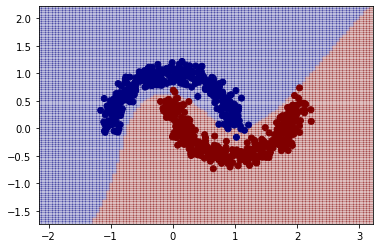

Error rate: 0.0107


In [ ]:
from sklearn.pipeline import Pipeline
learner3 = Pipeline([
              ("poly",PolynomialFeatures(degree=3, include_bias=False)),
              ("logreg", LogisticRegression())
            ])

learner3.fit(Xtr,ytr);
DecisionBoundaryDisplay.from_estimator(learner3, Xtr, **plot_kwargs)
plt.scatter(Xtr[:,0],Xtr[:,1], c=ytr);
plt.show()
print(f'Error rate: {np.round(J01(learner3.predict(Xtr),ytr),4)}')

Notice that we have asked ``scikit`` to do what you did manually in your linear regression homework: to first transform the features, then make a prediction.  The ``Pipeline`` object just implements a simple process -- when you ``fit`` a pipeline, it sequentially calls ``fit`` on each of its members in order, then calls ``transform`` on the training data before passing the output to the next member.  Then, when you call ``predict``, it sequentially calls ``transform`` on each member, finally calling ``predict`` on the last component.  You can easily place other transforms, such as ``StandardScaler``, in this pipeline as well.

This way, the 2D visualization (``DecisionBoundaryDisplay``) knows how to convert each 2D input point into the desired, 8-dimensional 

We can see that the resulting decision boundary is the solution to
$$ \theta_0 \ + \ \theta_1 x_1 + \theta_2 x_2 \ + \  \theta_3 x_1^2 + \theta_4 x_1 x_2 + \theta_5 x_2^2 \ + \ \theta_6 x_1^3 + \theta_7 x_1^2 x_2 + \theta_8 x_1 x_2^2 + \theta_{9} x_2^3 \quad = \quad 0$$
i.e., a perceptron (linear) decision boundary in an 8-dimensional feature space defined by powers of $x_1,x_2$.

In [ ]:
# If you want to check the order that PolynomialFeatures produces:
# poly.transform(np.array([[2,3]]))
# Out: array([[ 2.,  3.,  4.,  6.,  9.,  8., 12., 18., 27.]])

<center> <img src="http://sli.ics.uci.edu/extras/sep.png" alt="--------------------------------------------" width="200px" height="20px" style="width:200px;height:20px;"/> </center>


# Linear Classifiers and Loss Functions

Many different techniques are really the same learner (for example, a linear classifier) combined with a different choice of loss.  We have seen this in lecture, with Logistic-MSE, Logistic-NLL, and (shortly) hinge loss in SVMs.  Let's take a look in code:

### "Logisitic Regression" Linear Classifier

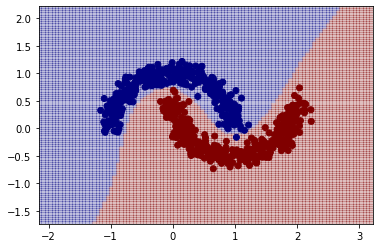

Error rate: 0.0027


In [ ]:
# "SGDClassifier" is a generic linear classifier trained using Stochastic Gradient Descent on some loss:

logreg_model = SGDClassifier(loss='log_loss')  # "log_loss" = logistic negative log-likelihood
learner = Pipeline([
              ("poly",PolynomialFeatures(degree=3, include_bias=False)),
              ("logreg", logreg_model)
            ])

learner.fit(Xtr,ytr);
DecisionBoundaryDisplay.from_estimator(learner, Xtr, **plot_kwargs)
plt.scatter(Xtr[:,0],Xtr[:,1], c=ytr);
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(Xtr),ytr),4)}')

### (Linear) "Support Vector Machine" Classifier

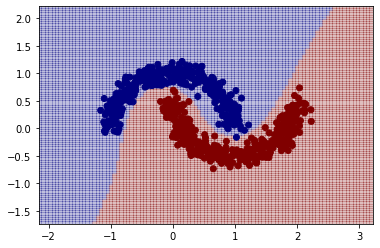

Error rate: 0.0


In [ ]:
# "SGDClassifier" is a generic linear classifier trained using Stochastic Gradient Descent on some loss:

# "hinge" = hinge loss; "soft margin" support vector machine
linsvm_model = SGDClassifier(loss='hinge',alpha=1e-8)  
# when alpha (=1/R) is small, we are equivalent to a "hard margin" SVM

learner = Pipeline([
              ("poly",PolynomialFeatures(degree=3, include_bias=False)),
              ("linsvm", linsvm_model)
            ])

learner.fit(Xtr,ytr);
DecisionBoundaryDisplay.from_estimator(learner, Xtr, **plot_kwargs)
plt.scatter(Xtr[:,0],Xtr[:,1], c=ytr);
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(Xtr),ytr),4)}')

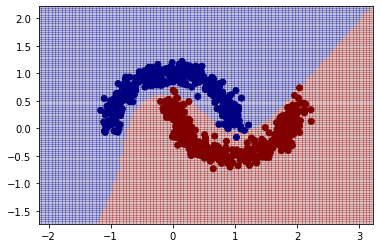

Error rate: 0.0053


In [ ]:

# "hinge" = hinge loss; "soft margin" support vector machine
linsvm_model = SGDClassifier(loss='hinge',alpha=1e-2)  
# when alpha (=1/R) is larger, we accept some errors (soft margin)
# in order to be farther away (larger margin) from "most" data

learner = Pipeline([
              ("poly",PolynomialFeatures(degree=3, include_bias=False)),
              ("linsvm", linsvm_model)
            ])

learner.fit(Xtr,ytr);
DecisionBoundaryDisplay.from_estimator(learner, Xtr, **plot_kwargs)
plt.scatter(Xtr[:,0],Xtr[:,1], c=ytr);
plt.show()
print(f'Error rate: {np.round(J01(learner.predict(Xtr),ytr),4)}')